## Imports and server setup

In [2]:
# parsing & plotting, later
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline

In [3]:
# for workflow management
import json
import os
from google.cloud import storage
import cromwell_manager as cwm

with open(os.path.expanduser('~/.ssh/mint_cromwell_config.json')) as f:
    cromwell_server = cwm.Cromwell(**json.load(f))
    storage_client = storage.Client(project='broad-dsde-mint-dev')

## Define and run the un-optimized workflows

In [1]:
wdl = '../count/count.wdl'
inputs = 'pbmc8k_inputs.json'
options = 'https://raw.githubusercontent.com/ambrosejcarr/cromwell-manager/master/src/accessories/long_call_caching.json'

In [6]:
full_monitored = cwm.Workflow.from_submission(wdl=wdl, inputs_json=inputs, options_json=options, cromwell_server=cromwell_server, storage_client=storage_client)
full_monitored_from_get_trimmed_aligned = cwm.Workflow.from_submission(wdl=wdl, inputs_json=inputs, options_json=options, cromwell_server=cromwell_server, storage_client=storage_client)

In [7]:
full_monitored = cwm.Workflow('52b9df91-088d-44b0-b3a8-5c5a6b542268', cromwell_server=cromwell_server, storage_client=storage_client)
full_monitored_from_get_trimmed_aligned = cwm.Workflow('d89225c5-b804-4b13-a8fb-98a71557c800', cromwell_server=cromwell_server, storage_client=storage_client)

## Parse the data; identify and save cost information

In [18]:
# here's what I did last time. This time I'll need to: 
# 1. merge the two tasks -- shouldn't be too bad, the second is a superset of the first. Account for possibility of None's (also make sure to commit that change! if it works)
# 2. find the average of each task over all the shards when possible, otherwise use the max 

max_memory = defaultdict(list)
available_memory = defaultdict(list)
max_disk = defaultdict(list)
available_disk = defaultdict(list)

def extract_info(task):
    """awful little side-effecting function to fill dictionaries"""
    ru = task.resource_utilization
    if ru is None:  # allow for None
        return
    max_memory[ru.task_name].append(ru.max_memory)
    max_disk[ru.task_name].append(ru.max_disk)
    available_memory[ru.task_name].append(ru.total_memory)
    available_disk[ru.task_name].append(ru.total_disk)

for task_name, calledtask1 in full_monitored_from_get_trimmed_aligned.tasks.items():
    
    # get the other run's tasks
    if task_name in full_monitored.tasks:
        calledtask2 = full_monitored.tasks[task_name]
        for shard in calledtask2._shards:
            extract_info(shard)
    
    for shard in calledtask1._shards:
        extract_info(shard)
    
mean_max_memory = {key: np.mean(val) for key, val in max_memory.items()}
max_max_memory = {key: np.max(val) for key, val in max_memory.items()}
std_max_memory = {key: np.std(val) for key, val in max_memory.items()}
mean_max_disk = {key: np.mean(val) for key, val in max_disk.items()}
max_max_disk = {key: np.max(val) for key, val in max_disk.items()}
std_max_disk = {key: np.std(val) for key, val in max_disk.items()}
available_memory = {key: np.mean(val) for key, val in available_memory.items()}
available_disk = {key: np.mean(val) for key, val in available_disk.items()}

parsed_data = pd.DataFrame({
    'mean_max_memory': mean_max_memory,
    'max_max_memory': max_max_memory,
    'std_max_memory': std_max_memory,
    'available_memory': available_memory,
    'mean_max_disk': mean_max_disk,
    'max_max_disk': max_max_disk,
    'std_max_disk': std_max_disk,
    'available_disk': available_disk
    
})

In [17]:
parsed_data  # memory utilization

,available_disk,available_memory,max_max_disk,max_max_memory,mean_max_disk,mean_max_memory,var_max_disk,var_max_memory
align_reads_main,1.031992e+09,60402.0,38558320,16527,3.801333e+07,16497.968354,432717.967862,11.990725
align_reads_split,1.031992e+09,30163.0,34067928,306,3.406793e+07,306.000000,0.000000,0.000000
attach_bcs_and_umis_join,1.031992e+09,30163.0,196448904,3590,1.964489e+08,3590.000000,0.000000,0.000000
chunk_reads_join,1.031992e+09,30163.0,73492,284,7.348200e+04,283.000000,10.000000,1.000000
chunk_reads_main,1.031992e+09,30163.0,285167928,366,2.849237e+08,330.250000,219745.497974,35.280129
chunk_reads_split,1.031992e+09,30163.0,73108,279,7.310800e+04,279.000000,0.000000,0.000000
count_genes_join,1.031992e+09,30163.0,19144628,2161,1.914463e+07,2161.000000,0.000000,0.000000
count_genes_main,1.031992e+09,30163.0,129857068,1621,1.297686e+08,1053.324873,19869.105920,131.910545
count_genes_split,1.031992e+09,30163.0,129761828,332,1.297618e+08,332.000000,0.000000,0.000000
extract_reads_join,1.031992e+09,30163.0,305387868,562,3.053865e+08,538.000000,1380.000000,24.000000


In [7]:
# save the data to file
parsed_data = pd.read_csv('pbmc8k_mem_diskusage_data.csv', index_col=0)
parsed_data.to_csv('pbmc8k_mem_diskusage_data.csv')

## Plot utilization vs requested resources

In [19]:
def barplot(dataframe, column, label, ax, *args, **kwargs):
    ax.bar(left=np.arange(dataframe.shape[0]), height=dataframe[column], *args, **kwargs)
    ax.set_xticks(np.arange(dataframe.shape[0]));
    ax.set_xticklabels(list(i.replace('singlesample.Ss2RunSingleSample.', '') for i in dataframe.index), rotation=90)
    ax.set_xlim((-0.6, dataframe.shape[0] - 0.4));
    ax.set_ylabel(label)

/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:1710: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


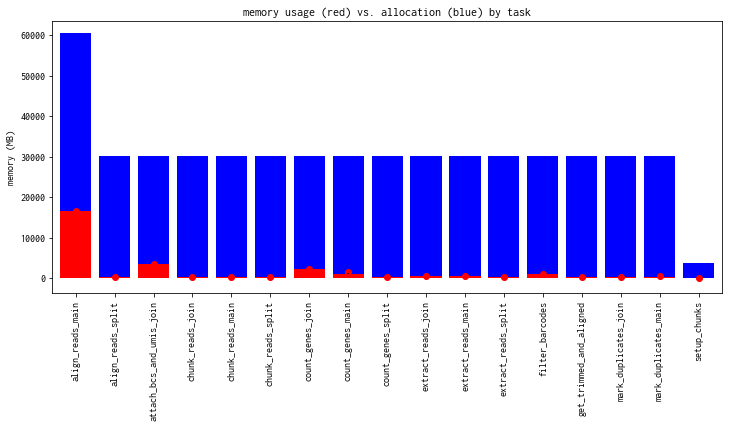

In [25]:
f, ax = plt.subplots(figsize=(12, 5))
barplot(dataframe=parsed_data, column='available_memory', label='memory (MB)', zorder=0, ax=ax, facecolor='b')
barplot(dataframe=parsed_data, column='mean_max_memory', label='memory (MB)', zorder=1, ax=ax, facecolor='r', 
        yerr=parsed_data['std_max_memory'])
plt.scatter(np.arange(parsed_data.shape[0]), parsed_data['max_max_memory'], c='r')
plt.title('memory usage (red) vs. allocation (blue) by task');

/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:1710: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


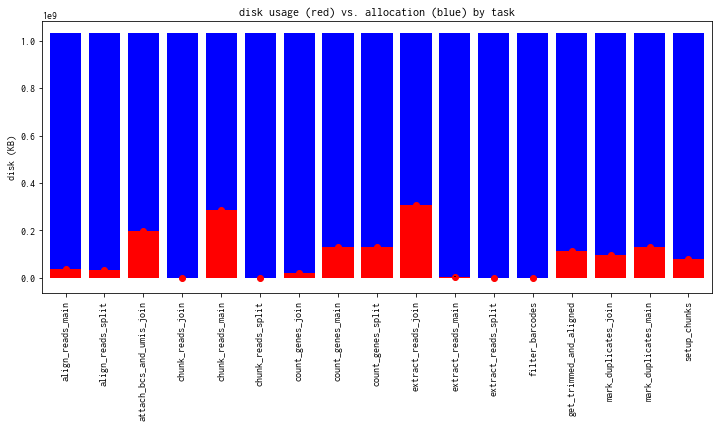

In [26]:
f, ax = plt.subplots(figsize=(12, 5))
barplot(dataframe=parsed_data, column='available_disk', label='disk (KB)', zorder=0, ax=ax, facecolor='b')
barplot(dataframe=parsed_data, column='mean_max_disk', label='disk (KB)', zorder=1, ax=ax, facecolor='r', 
        yerr=parsed_data['std_max_disk'])
plt.scatter(np.arange(parsed_data.shape[0]), parsed_data['max_max_disk'], c='r')
plt.title('disk usage (red) vs. allocation (blue) by task');

## Run the resource-optimized count on test data. 

I'm running with call caching, and docker was doing weird things, so the cost won't be accurate. 

In [65]:
wdl = '/Users/carra1/projects/skylab/10x/count/count.wdl'
pbmc8k_inputs = 'pbmc8k_inputs.json'
inputs_json = '/Users/carra1/projects/skylab/10x/count/example_count_input.json'
options = '/Users/carra1/projects/cromwell-manager/src/accessories/options.json'
monitor = {"monitoring_script": "gs://broad-dsde-mint-dev-teststorage/10x/benchmark/scripts/monitor.sh"}

In [99]:
test_monitored_small = cwm.Workflow.from_submission(wdl=wdl, inputs_json=inputs_json, cromwell_server=cromwell_server, storage_client=storage_client)

In [61]:
test_monitored_small.status

{'id': '9d7ac6a4-fc02-41cf-82e4-af841d720634', 'status': 'Succeeded'}

In [124]:
os.environ['wdltool'] = os.path.expanduser('~/google_drive/software/wdltool-0.14.jar')
test_monitored = cwm.Workflow.validate(
    wdl=wdl, 
    inputs_json=pbmc8k_inputs, 
    options_json={"monitoring_script": "gs://broad-dsde-mint-dev-teststorage/10x/benchmark/scripts/monitor_long.sh"},
    cromwell_server=cromwell_server, 
    storage_client=storage_client)

CWM:2017-10-25 09:50:47.700076:creating temporary directory
CWM:2017-10-25 09:50:47.700664:writing wdl
CWM:2017-10-25 09:50:47.701140:running wdltool validate
CWM:2017-10-25 09:50:48.966942:validation successful
CWM:2017-10-25 09:50:49.265370:checking docker image marcusczi/cellranger_clean:cromwell... OK.


In [122]:
test_monitored = cwm.Workflow.from_submission(
    wdl=wdl, 
    inputs_json=pbmc8k_inputs, 
    options_json={"monitoring_script": "gs://broad-dsde-mint-dev-teststorage/10x/benchmark/scripts/monitor_long.sh"},
    cromwell_server=cromwell_server, 
    storage_client=storage_client)

In [137]:
test_monitored.status

{'id': 'cbf9c3cd-4a23-4ac2-9e12-78969151a44a', 'status': 'Succeeded'}

Carry out the cost analysis even though docker took 100x longer than it should have. 

In [141]:
import requests

script_data = requests.get('https://raw.githubusercontent.com/ambrosejcarr/cromwell-manager/master/src/accessories/calculate_workflow_cost.py')
with open('get_cost.py', 'wb') as f:
    f.write(script_data.content)

md = test_monitored.metadata
with open('run_metadata.json', 'w') as f:
    json.dump(md, f)

In [150]:
!python2.7 get_cost.py -m run_metadata.json --only_total

Total Cost: 188.704169977
